In [1]:
import pandas as pd

dpath = '../data/sample_input.json'

df = pd.read_json(dpath, lines=True)
df

,reviewText,overall
0,I always get a half size up in my tennis shoes...,3
1,Put them on and walked 3 hours with no problem...,5
2,excelente,5
3,The shoes fit well in the arch area. They are ...,4
4,Tried them on in a store before buying online ...,5
...,...,...
372,Favorite Nike shoe ever! The flex sole is exce...,5
373,"I wear these everyday to work, the gym, etc.",5
374,"Love these shoes! Great fit, very light weight.",5
375,Super comfortable and fit my small feet perfec...,5


In [2]:
df_reviews = df.loc[df.astype('str').drop_duplicates().index]
df_reviews

,reviewText,overall
0,I always get a half size up in my tennis shoes...,3
1,Put them on and walked 3 hours with no problem...,5
2,excelente,5
3,The shoes fit well in the arch area. They are ...,4
4,Tried them on in a store before buying online ...,5
...,...,...
372,Favorite Nike shoe ever! The flex sole is exce...,5
373,"I wear these everyday to work, the gym, etc.",5
374,"Love these shoes! Great fit, very light weight.",5
375,Super comfortable and fit my small feet perfec...,5


In [3]:
import spacy
import pytextrank
from spacy.language import Language
from spacy_readability import Readability
from importlib.util import find_spec

@Language.component("readability")
def readability(doc):
    read = Readability()
    doc = read(doc)
    return doc

pipe_name = 'en_core_web_md'

if find_spec(pipe_name) is None:
    spacy.cli.download(pipe_name)

nlp = spacy.load(pipe_name)
nlp.add_pipe("textrank", last=True)
nlp.add_pipe("readability", last=True)

<function __main__.readability(doc)>

In [4]:
stopwords = list(nlp.Defaults.stop_words)

def apply_ranking(doc, trt):
    results = []
    for token in doc._.phrases:
        text = token.text
        text = text.lower().split(' ')
        text = filter(lambda x: x not in stopwords, text)
        text = ' '.join(text)
        if token.rank and token.rank >= trt:
            results.append((text, token.rank))
    return results

def apply_readability(doc):
    return doc._.flesch_kincaid_reading_ease

In [5]:
scores = []
docs = nlp.pipe(texts=df_reviews['reviewText'].astype('str'))
for doc in docs:
    scores.append([apply_ranking(doc, 0), apply_readability(doc)])
print('Size:', len(scores))
print('Sample:', scores[0])

Size: 371
Sample: [[('tennis shoes', 0.12971597081854963), ('heel area', 0.11278192619619307), ('half', 0.053635551595810474), ('reason', 0.04734609155372741)], 92.43000000000002]


In [6]:
df_reviews['ranks'] = [p[0] for p in scores]
df_reviews['n_tokens'] = [len(p[0]) for p in scores]
df_reviews['readability'] = [p[1] for p in scores]
df_reviews.sort_values(by='n_tokens', ascending=False)
# df_reviews['readability'] = (df_reviews['readability'].max() - df_reviews['readability']) / (df_reviews['readability'].max() - df_reviews['readability'].min())
df_reviews.sort_values(by='n_tokens', ascending=False)

,reviewText,overall,ranks,n_tokens,readability
320,Favorite training and walking-around sneakers....,5,"[(gym use, 0.09606191299609641), (flex supreme...",39,70.526224
355,I am a recess aide and on my feet all day long...,4,"[(hip pain, 0.13045310873361876), (time, 0.111...",35,87.037802
325,I LOVE the look and comfort of these shoes for...,3,"[(major issues, 0.16276363627717572), (shoes, ...",31,90.683676
64,"Super light-weight, decent arch support (mine ...",5,"[(shoes, 0.15014668465326747), (shoe, 0.150146...",28,65.562910
57,Very good overall.\nNow Ive been a huge Sketch...,4,"[(walt disney world, 0.12001095576359547), (so...",26,78.244199
...,...,...,...,...,...
71,great,5,[],0,121.220000
72,c,5,[],0,121.220000
73,Love them!,5,[],0,120.205000
131,Luv them!!,5,[],0,120.205000


In [7]:
import gensim.downloader as api


model_name = 'word2vec-google-news-300' 

# HACK: Temporary fix -@jiqi at 11/18/2022, 10:23:14 AM
# This line checks if the model file is ready and then load it.
model = api.load(model_name) 

In [9]:
import numpy as np

tokens = []
for phrases_rank in list(df_reviews['ranks']):
    for phrase in phrases_rank:
        phrase = phrase[0]
        if phrase: tokens.append(phrase)
tokens = np.array(tokens)
len(tokens)

1507

In [10]:
from itertools import starmap, combinations

combis = list(combinations([t.split(' ') for t in tokens], 2))
combis[0]

(['tennis', 'shoes'], ['heel', 'area'])

In [11]:
from itertools import starmap

# FIXME: seems not correct to pass strings as input, but should be list of strings (words)
# In the souce code of wmdistance function, it checks if the words in the input documents
# are there in the keyedvector model. If not, a inf distance will be given to that pair.
# But if the input is document as string but not a list of words included, it will always
# calculate the distance by English charactors, which will always return a value in [0, 1l]
dists = list(starmap(model.wmdistance, combis))

In [12]:
import numpy as np

dists = np.nan_to_num(dists, nan=0, posinf=100)
data = np.zeros((len(tokens), len(tokens)))
data[np.triu_indices(len(tokens), 1)] = dists
data = data + data.T
df_matrix = pd.DataFrame(data, index=tokens, columns=tokens)

In [13]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

assert not df_matrix.empty

cluster_labels = None
silhouette_target = -float('inf')
for i in range(min(df_matrix.index.size, 10)):
    cluster = KMeans(n_clusters=(i+1), random_state=10)
    labels = cluster.fit_predict(df_matrix)
    try: 
        silhouette = silhouette_score(df_matrix, labels)
    except:
        silhouette = 0
    if silhouette > silhouette_target:
        silhouette_target = silhouette
        cluster_labels = labels

print(silhouette_target)
np.histogram(cluster_labels, bins=list(range(10)))

0.9971132581245241


(array([1475,   32,    0,    0,    0,    0,    0,    0,    0]),
 array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]))

In [14]:
def get_cluster_set(tokens: np.array, token_dictionary: np.array, cluster_labels: np.array) -> set:
    indices = np.isin(token_dictionary, tokens)
    clusters = cluster_labels[indices]
    return set(clusters.flatten())

t1 = np.array([1, 2, 3])
t2 = np.array([4, 6])
td = np.array([0, 1, 2, 3, 4, 5, 6])
cl = np.array(["a", "a", "b", "b", "a", "b", "c"])

s1 = get_cluster_set(t1, td, cl)
s2 = get_cluster_set(t2, td, cl)
if s1 & s2:
    print("Interaction exists!")
else:
    print("No interaction!")


Interaction exists!


In [15]:
# TODO: Tasks pending completion -@jiqi at 11/22/2022, 4:32:16 PM
# 0. check all the todo
# 1. df_review group by score
# 2. iterate over the group
#   2.1 for each token in the current group, check with all tokens in unvisited groups than itself
#   2.2 get cluster sets and compute possible attackings
#   2.3 store in the result network df
# 3. labeling: 
#   3.0 undescribe round: all nodes are initialized by undescribe 
#   3.1 support round: for each node, if all its attachers are attacked, than support
#   3.2 defeat round: for each undescribe node, if it is attacked by any supported node, label it 
#       with defeat
assert tokens.size == cluster_labels.size

source = []
destination = []
weight = []

for curr_group in range(1, 5):
    df_src = df_reviews[df_reviews['overall'] == curr_group]
    df_dst = df_reviews[df_reviews['overall'] > curr_group]

    for i_src, row_src in df_src.iterrows():
        if not row_src['ranks']:
            continue
        query_src = np.array([t[0] for t in row_src['ranks']])
        clusters_src = get_cluster_set(query_src, tokens, cluster_labels)
        w_src = max([t[1] for t in row_src['ranks']]) * row_src['readability']
        for i_dst, row_dst in df_dst.iterrows():
            query_dst = np.array([t[0] for t in row_dst['ranks']])
            clusters_dst = get_cluster_set(query_dst, tokens, cluster_labels)
            
            # two reviews share tokens belonging to the same cluster
            if clusters_src and clusters_dst:
                w_dst = max([t[1] for t in row_dst['ranks']]) * row_dst['readability']

                # get attacking direction
                if w_src >= w_dst:
                    source.append(i_src)
                    destination.append(i_dst)
                    weight.append(w_src)
                else:
                    source.append(i_dst)
                    destination.append(i_src)
                    weight.append(w_dst)

<AxesSubplot: ylabel='Frequency'>

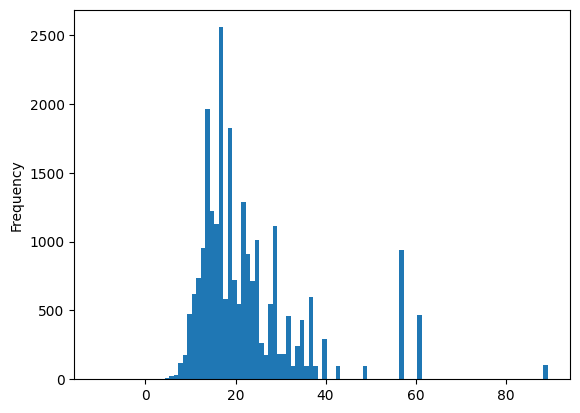

In [101]:
df_network = pd.DataFrame({
    'source': source, 
    'destination': destination, 
    'weight': weight 
})

df_network['weight'].plot.hist(bins=100)

In [102]:
# pruning network by weight
theta = 50
df_network = df_network[df_network['weight'] >= theta]
df_network.shape

(1511, 3)

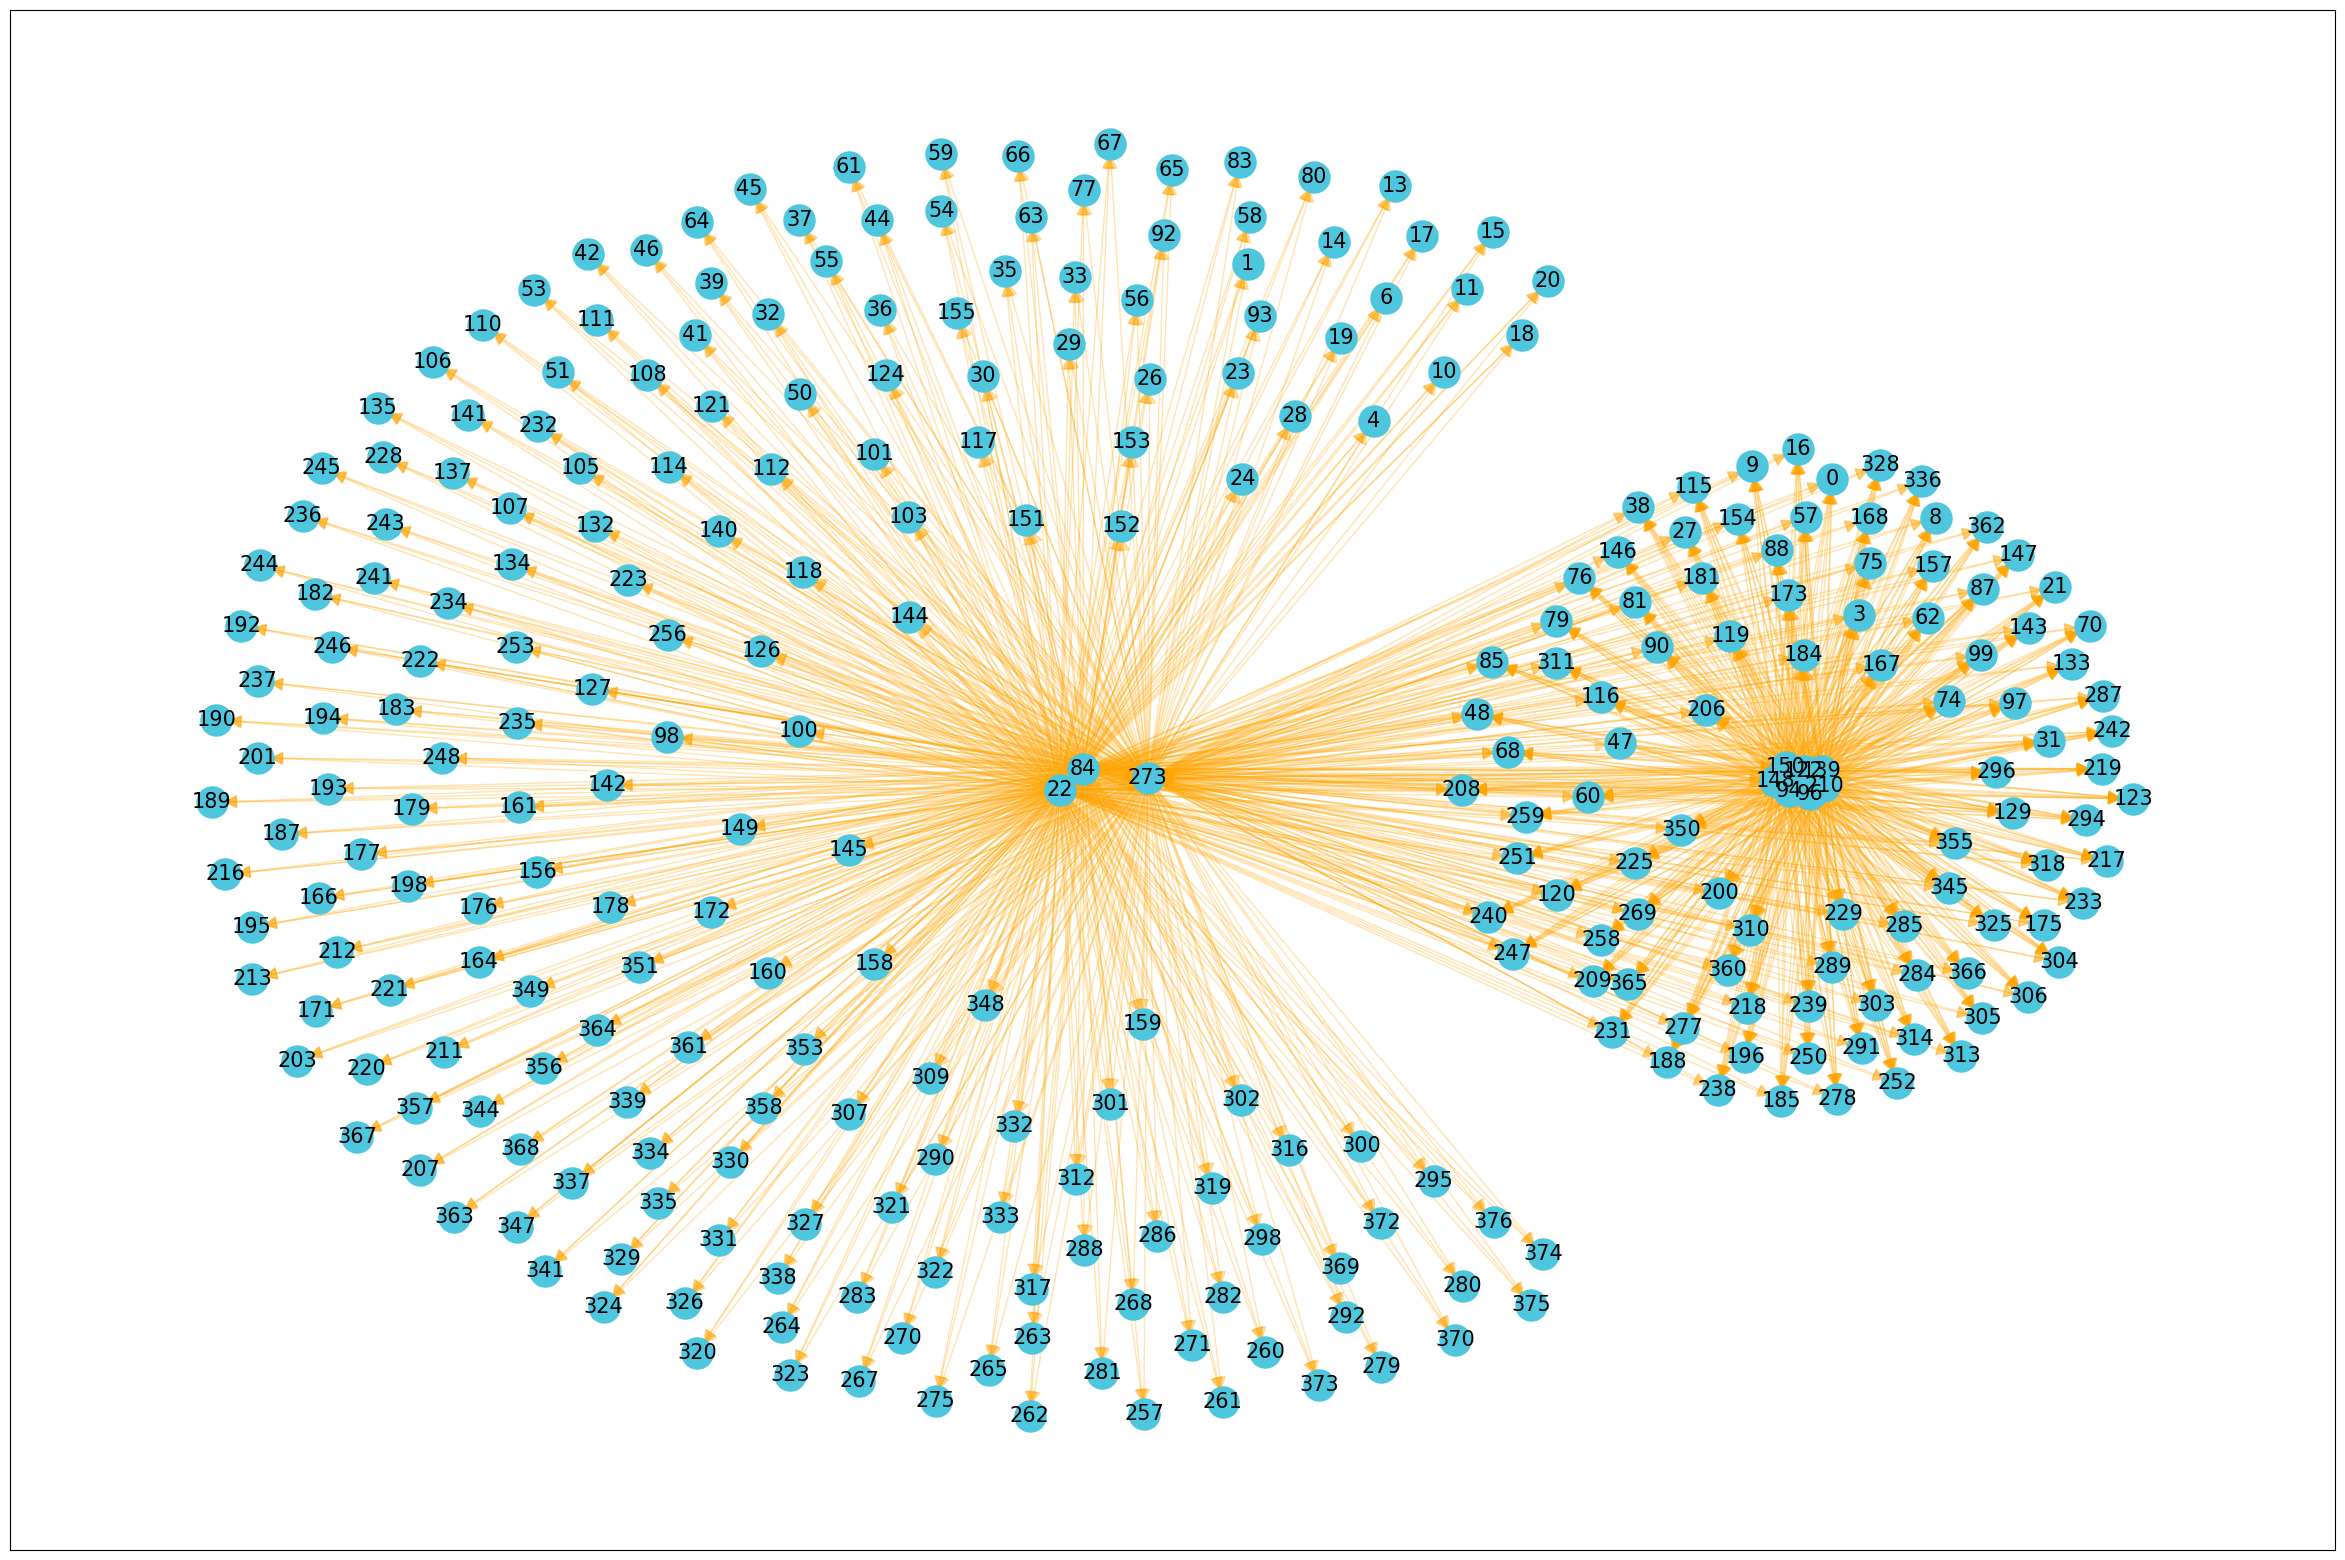

In [103]:
import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout
import matplotlib.pyplot as plt

G = nx.from_pandas_edgelist(df_network, source='source', target='destination', edge_attr=['weight'])

# check possible layouts: https://graphviz.org/docs/layouts/
pos = graphviz_layout(G, prog='sfdp', args='')

plt.figure(1, figsize=(30, 20))
nx.draw_networkx_edges(G, pos, arrows=True, arrowsize=20, arrowstyle='-|>', edge_color='orange', alpha=.3)
nx.draw_networkx_nodes(G, pos, node_size=500, node_color='#4ec6de')
nx.draw_networkx_labels(G, pos, font_size=15)
plt.show()

In [122]:
def review_info(i):
    print('Review %d (score %d): %s' % (i, df_reviews.loc[i]['overall'], df_reviews.loc[i]['reviewText']))

def attack_info(a, d):
    try:
        w = G[a][d]['weight']
    except:
        print('No attack from %d to %d!' % (a, d))
        return
    print('Attack %d -> %d: %f' % (a, d, w))

review_info(84)
review_info(273)
review_info(159)
attack_info(84, 159)
attack_info(273, 159)

Review 84 (score 4): Nice fit
Review 273 (score 1): wrong shoes
Review 159 (score 5): they are very comfortable feel like you have nothing on.
Attack 84 -> 159: 56.665180
Attack 273 -> 159: 56.665180


In [158]:
import networkx as nx

G = nx.path_graph(10)
labels = {}
for node in G:
    if node % 2:
        labels[node] = 'odd'
    else:
        labels[node] = 'even'
nx.set_node_attributes(G, labels, name='labels')
G.nodes[3]


{'labels': 'odd'}

##  Exploration on speeding up the process of computing pair-wise wmdistances

#### Simple for-loop

Also tried numpy.vectorize(), but no improvement as well.

In [35]:
# simple for loop performs similarly as itertools.starmap
dists_for = [model.wmdistance(c[0], c[1]) for c in combis]

#### Multiprocessing

In [38]:
from multiprocessing import Pool, cpu_count
from functools import partial

def calc_wmdistance(model, doc1, doc2):
    return model.wmdistance(doc1, doc2)

job = partial(calc_wmdistance, model)

with Pool(processes=cpu_count()) as pool:
    # # async function
    # result = pool.starmap_async(job, combis)
    # data = result.get()

    # sync function
    # data = pool.starmap(job, combis, chunksize=10)
    data = pool.starmap(job, combis)
    

: 

: 

#### joblib

It's hard to get the desired speedup by directly applying mp or joblib to the static version of the function, as the model is likely quite large and pickle-sending it to the child processes for each calculation dominates the runtime.

In [3]:
from joblib import Parallel, delayed


# can't use the instance_bound function directly here, so use the static version instead
result = Parallel(n_jobs=-2)(calc_wmdistance(model, combi) for combi in combis)

#### Rewrite the wmdistance function as static

To solve the pickle-sending issue above, a possible solution is to have the model (actually only a very large array is needed) defined globally and stored in a shared memory so that the child processes can get access to them directly.

However, this also doesn't work. The kernel even crashed before finishing computation.

In [12]:
# static version of the wmdistance function, with shared memory of storing the
# word index and vectors generated by the gensim model. 

from pyemd import emd
from multiprocessing import Manager, RawArray
import numpy as np
from gensim.corpora.dictionary import Dictionary
from scipy.spatial.distance import cdist

# shared memory that stored the token index and vectors
# HACK: it would be useful to reduce the size of the index and vectors by the exact 
# dictionary.
TOKEN_INDEX = Manager().list(model.index_to_key)
v_shape = model.vectors.shape
vectors = RawArray('f', v_shape[0] * v_shape[1])
TOKEN_VECTORS = np.frombuffer(vectors, dtype=np.float32).reshape(v_shape)
np.copyto(TOKEN_VECTORS, model.vectors)


def init_pool(shared_t_index, shared_t_vectors):
    global t_index, t_vectors
    t_index = shared_t_index
    t_vectors = shared_t_vectors

def calc_wmdistance(doc1, doc2):
    doc1 = [w for w in doc1 if w in t_index]
    doc2 = [w for w in doc2 if w in t_index]

    # if any of the input is empty, return inf
    if not doc1 or not doc2: return float('inf')

    dictionary = Dictionary(documents=[doc1, doc2])
    vocab_len = len(dictionary)

    # if both input docs contain the same unique token, return 0
    if vocab_len == 1: return 0.0

    doclist1 = list(set(doc1))
    doclist2 = list(set(doc2))

    # get list of word vectors for each document
    v1 = []
    for w in doclist1:
        i = t_index.index(w)
        v = t_vectors[i]
        v = v / np.linalg.norm(v)
        v1.append(v)
    v1 = np.array(v1)
    v2 = []
    for w in doclist2:
        i = t_index.index(w)
        v = t_vectors[i]
        v = v / np.linalg.norm(v)
        v2.append(v)
    v2 = np.array(v2)

    # compute distance matrix
    doc1_indices = dictionary.doc2idx(doclist1)
    doc2_indices = dictionary.doc2idx(doclist2)
    distance_matrix = np.zeros((vocab_len, vocab_len), dtype=np.double)
    distance_matrix[np.ix_(doc1_indices, doc2_indices)] = cdist(v1, v2)

    # if distance matrix is all zero, return inf
    if abs(np.sum(distance_matrix)) < 1e-8: return float('inf')

    d1 = np.zeros(vocab_len, dtype=np.double)
    d2 = np.zeros(vocab_len, dtype=np.double)
    doc1_len = len(doc1)
    doc2_len = len(doc2)
    for i, f in dictionary.doc2bow(doc1):
        d1[i] = f / float(doc1_len)
    for i, f in dictionary.doc2bow(doc2):
        d2[i] = f / float(doc2_len) 
    
    return emd(d1, d2, distance_matrix)

# # test if the output is the same as the original function
# doc1 = tokens[0]
# doc2 = tokens[1]
# calc_wmdistance(doc1, doc2) == model.wmdistance(doc1.split(' '), doc2.split(' '))

In [15]:
from multiprocessing import Pool, cpu_count

with Pool(processes=cpu_count() - 1, initializer=init_pool, initargs=(TOKEN_INDEX, TOKEN_VECTORS, )) as pool:
    data = pool.starmap_async(calc_wmdistance, combis, chunksize=10)
    result = data.get()